### Importing modules

In [43]:
import nltk
import os, sys
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV, KFold
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from wordcloud import WordCloud

### Constants

In [5]:
# file names
train_file = "train.csv"
test_file = "test.csv"
clean_tweets_train_file= "clean_tweets_train_file.csv"
clean_tweets_test_file = "clean_tweets_test_file.csv"
term_freq_file = "term_freq_file.csv"

sentiment_dict = {
    "negative": 0,
    "neutral": 2,
    "positive": 4
}

negations_dict = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}

# emoticon dictionary
dict = {
    "E_SMILEY" :[":)", ":-)","(:", "(-:", "8)", "8-)", "0:)", "0:-)" ],
    "E_LAUGH" :[":D", ":-D", "XD", "X-D", "xD", "8D", "8-D"],
    "E_TEASE" : [":P", ":-P", ":p", ";P", "xp"],
    "E_LOVE" : ["<3", ";*", ":*"],
    "E_WINK": [";-)", ";)", ";-D", ";D", "(;", "(-;"],
    "E_FROWN":[":(", ":-(", "):", ")-:"],
    "E_ANGER" :[":c", ":-c", ":<", ":-<", ":[", ":-[", ":-||", ":@", ">:("],
    "E_CRY": [":,(", ":'(", ":''(", ":(("]

}
emoticon_dict = {}
for key in dict.keys():
    for emoticon in dict[key]:
        emoticon_dict[emoticon] = key
        
capitals = ['USER', "URL", "HANDLE"]
for key in dict.keys():
    capitals.append(key)

class_distribution = {}  # dict with key as sentiment, value as number of tweets of that sentiment

In [6]:
# preparing custom stops words list (stops)

negative_words = list(negations_dict.keys())

n = ['against', 'after', 'aren', 'ain', 'but', "can't", 'during', 'further', "mightn", "mightn't", "mustn", "not",
     "nor", "off", "over", "once", "such","hadn", "shan't", "shouldn", "need't", "didn", "doesn", "wasn", "wouldn",
     "needn't", "hasn" ]
for word in n:
    negative_words.append(word)

stops = set(stopwords.words("english"))
for word in negative_words:
    if word in stops:
        stops.remove(word)


## Functions
___________________________________

### get_class_names()
 * **pred** - sentiment predictions in the form of numbers (0, 2, 4)
 * **sentiment_dict** - dictionary with sentiment as key, and it's corresponding number as value
 * **predicted_sentiment** - a list of predicted sentiment (positive/neutral/negative)

In [52]:
def get_class_names(pred):
    predicted_sentiment = []
    for i in pred:
        for key in sentiment_dict.keys():
            if i == sentiment_dict[key]:
                predicted_sentiment.append(key)
    return predicted_sentiment

### load_data_from_file()
 * **file_name** - csv file which is to be read 
 * **df** - returned pandas.DataFrame

In [8]:
def load_data_from_file(file_name):
    df = pd.read_csv(file_name)
    print("The details of the data in the file : ", file_name)
    print("Number of tweets (rows): ", df.shape[0])
    print("Number of features (columns): ", df.shape[1])
    print("Columns : ", df.columns)
    print()
    return df

### get_simple_pos()
* converts the pos_tag

In [9]:
def get_simple_pos(tag):
    
    if tag.startswith('J'):                                            # adjective
        return wordnet.ADJ
    
    elif tag.startswith('N'):                                          # noun
        return wordnet.NOUN 
    
    elif tag.startswith('V'):                                          # verb
        return wordnet.VERB
    
    elif tag.startswith('R'):                                          # adverb
        return wordnet.ADV
    
    else:
        return wordnet.NOUN

### get_stopwords()
* returns custom list of **stopwords**, which contains punctuation also

In [10]:
def get_stopwords():
    stops = []
    punctuations = string.punctuation                               # punctuation                                  
    stops = stops + list(punctuations)                              # concatenation of list
    stops.append('handle')
    stops.append('url')
    stops.remove('!')
    stops.remove('?')
    return stops

### get_useful_df()
* **df**- pandas.DataFrame from testing and training data files
* deletes the redundant columns from *df*
* returns the updated *df*

In [11]:
def get_useful_df(df):
    # columns not needed
    df.drop(["airline", "tweet_id", "airline_sentiment_gold", "name", "negativereason_gold",
                 "tweet_coord", "tweet_location", "user_timezone", "retweet_count", "tweet_created"],
                axis = 1, inplace = True)
    return df

### process_tweet()
* returns the clean **tweet**
* **tweet** - current tweet to be cleaned
* **Cleaning steps**
> * converts urls to *URL*
  * converts @username to *HANDLE*
  * removes extra white space
  * converts #hastag to hashtag
  * replaces *n't* with *not*
  * removes repetitive puntuation marks
  * converts emoticon to its class value using dictionary
  * converts *whattt* to *what*
  * tokenizes
  * lemmatizes 
 

In [12]:
def process_tweet(tweet):
    
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL',tweet)
    
    #Convert @username to HANDLE
    tweet = re.sub('@[^\s]+','HANDLE',tweet)
    
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #Replace #hashtag with hashtag
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    
    # replace n't with not
    tweet = re.sub('n\'t', ' not', tweet)
    #trim
    tweet = tweet.strip('\'"')
    
    # replace repetitive punctuation (. !) with single occurence
    tweet = re.sub(r'(\.)\1+', r'\1 ', tweet)
    tweet = re.sub(r'(!)\1+', r'\1 ', tweet)
    
    # replace emoticon with the emotion name
    for key in emoticon_dict.keys():
        if key in tweet:
            tweet = tweet.replace(key, emoticon_dict[key])
    
    stops = get_stopwords()
    
    lemmatizer = WordNetLemmatizer()
    
    # tokenize
    tweet = word_tokenize(tweet)
    
    for i in range(len(tweet)):
        if not wordnet.synsets(tweet[i]):
            #Not an English Word
            tweet[i] = re.sub(r'([a-z])\1+', r'\1', tweet[i])
    
    
    words = []
    for t in tweet:
        if t.lower() not in stops:
            pos = pos_tag([t])
            clean_word = lemmatizer.lemmatize(t, pos = get_simple_pos(pos[0][1])) 
            # 0th entry will give the tuple. then 1is tag
            if clean_word not in capitals:
                words.append(clean_word.lower())
            else:
                words.append(clean_word)
    # form the sentence again            
    text = ' '.join(word for word in words)
    text = text.strip()
    return text

### get_clean_tweets_df
* **df** - DataFrame whose tweets are to be cleaned
* **is_train** - Boolean value to specify whether the *df* is training or testing data
* calls **process_tweet()** for each *tweet* in *df*
* returns **clean_df** - DataFrame with cleaned tweets

In [13]:
def get_clean_tweets_df(df, is_train):
    clean_tweets = []
    for index in range(len(df)):
        clean = process_tweet(df.text[index])                               # get the cleaned tweet
        clean_tweets.append(clean)                                          # add to clean list

    clean_df = pd.DataFrame(clean_tweets, columns=['tweet'])                # create DataFrame
    if is_train:
        clean_df["sentiment"] = train_df.sentiment                          # sentiment added, if data is training data
    return clean_df

### draw_wordcloud()
* draws a wordcloud for the tweets of a particular *sentiment_value* to give better insight into the data
* **sentiment_value** - the value of the sentiment for which wordcloud is to be made
* **colormap** - *colormap* property of matplotlib
* returns DataFrame of the tweets of *sentiment_value*

In [14]:
def draw_wordcloud(sentiment_value, colormap):
    tweets = clean_train_df[clean_train_df.sentiment == sentiment_value]
    str = []
    for t in tweets.tweet:
        str.append(t)
    str = pd.Series(str).str.cat(sep=' ')

    from wordcloud import WordCloud

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap = colormap).generate(str)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return tweets

### show_wordclouds()
* calls **draw_wordcloud()** for each sentiment

In [15]:
def show_wordclouds():
    print("Wordcloud for Negative tweets - ")
    neg_tweets = draw_wordcloud(sentiment_dict["negative"], 'viridis')
    print("Wordcloud for Positive tweets - ")
    pos_tweets = draw_wordcloud(sentiment_dict["positive"], 'magma')
    print("Wordcloud for Neutral tweets - ")
    neu_tweets = draw_wordcloud(sentiment_dict["neutral"], 'plasma')
    

### LR()
* **param_grid** -  a grid of hyperparameters to be tuned using GridSearchCV
* uses **LogisticRegression** to classify the sentiments
* prints the required metrics
* returns **predicted_sentiment** list

In [53]:
def LR(x_train, y_train, x_test, param_grid):
    print("Results for Logistic Regression: ")
    clf = LogisticRegression(class_weight = 'balanced')
    grid_search = GridSearchCV(clf, param_grid, cv=KFold(n_splits = 10, shuffle= True, random_state=1))
    grid_search.fit(x_train, y_train)
    print("Score : ")
    print(grid_search.score(x_train,  y_train))
    predictions = grid_search.predict(x_test)
    print("Classification report :")
    print(classification_report(y_train, predictions))
    predicted_sentiment = get_class_names(predictions)
    return predicted_sentiment

### NB()
* uses **MultinomalNB** to classify the sentiments
* prints the required metrics
* returns **predicted_sentiment** list

In [54]:
def NB(x_train, y_train, x_test):
    print("Results for Multinomial Naive Bayes Classifier: ")
    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    predictions = nb.predict(x_test)
    nb.score(x_train_features_dense, clean_train_df.sentiment)
    print("Score : ")
    print(nb.score(x_train,  y_train))
    predictions = nb.predict(x_test)
    print("Classification report :")
    print(classification_report(y_train, predictions))
    predicted_sentiment = get_class_names(predictions) 
    return predicted_sentiment

### RF()
* uses **RandomForestClassifier** to classify the sentiments
* prints the required metrics
* returns **predicted_sentiment** list

In [62]:
def RF(x_train, y_train, x_test):
    print("Results for Random Forest Classifier: ")
    rf =RandomForestClassifier()
    rf.fit(x_train, y_train)
    predictions = rf.predict(x_test)
    rf.score(x_train_features_dense, clean_train_df.sentiment)
    print("Score : ")
    print(rf.score(x_train,  y_train))
    predictions = rf.predict(x_test)
    print("Classification report :")
    print(classification_report(y_train, predictions))
    predicted_sentiment = get_class_names(predictions)  
    return predicted_sentiment

## Main code
______________________________________________________

### Loading data

In [65]:
# read data from the csv files and print details

raw_train_df = load_data_from_file(train_file)
raw_test_df = load_data_from_file(test_file)

The details of the data in the file :  train.csv
Number of tweets (rows):  10980
Number of features (columns):  12
Columns :  Index(['tweet_id', 'airline_sentiment', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')

The details of the data in the file :  test.csv
Number of tweets (rows):  3660
Number of features (columns):  11
Columns :  Index(['tweet_id', 'airline', 'airline_sentiment_gold', 'name',
       'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_location', 'user_timezone'],
      dtype='object')



In [21]:
# remove features that are not required

train_df = get_useful_df(raw_train_df)
test_df = get_useful_df(raw_test_df)

In [22]:
train_df.head(3)

,airline_sentiment,text
0,negative,"@SouthwestAir I am scheduled for the morning, ..."
1,positive,@SouthwestAir seeing your workers time in and ...
2,positive,@united Flew ORD to Miami and back and had gr...


In [23]:
test_df.head(3)

,text
0,@AmericanAir In car gng to DFW. Pulled over 1h...
1,"@AmericanAir after all, the plane didn’t land ..."
2,@SouthwestAir can't believe how many paying cu...


In [24]:
# find class_distribution

distribution = train_df.airline_sentiment.value_counts()
for key in distribution.keys():
    class_distribution[key] = distribution[key]
print(class_distribution)                                   # no of data points in each class

{'negative': 6851, 'neutral': 2327, 'positive': 1802}


In [25]:
def string_to_number(s):
    return sentiment_dict[s]

In [26]:
# converting class to number

train_df["sentiment"] = train_df["airline_sentiment"].apply(string_to_number)
del train_df["airline_sentiment"]

In [27]:
train_df.head()

,text,sentiment
0,"@SouthwestAir I am scheduled for the morning, ...",0
1,@SouthwestAir seeing your workers time in and ...,4
2,@united Flew ORD to Miami and back and had gr...,4
3,@SouthwestAir @dultch97 that's horse radish 😤🐴,0
4,@united so our flight into ORD was delayed bec...,0


### Preprocessing data

In [28]:
# clean all the tweets 

clean_train_df = get_clean_tweets_df(train_df, True)
clean_test_df = get_clean_tweets_df(test_df, False)

In [29]:
clean_train_df.head()

,tweet,sentiment
0,i be schedule for the morning 2 day after the ...,0
1,see your worker time in and time out go above ...,4
2,flew ord to miami and back and have great crew...,4
3,that 's horse radish 😤🐴,0
4,so our flight into ord be delayed because of a...,0


In [30]:
clean_test_df.head()

,tweet
0,in car gng to dfw pulled over 1hr ago very icy...
1,after all the plane didn ’ t land in identical...
2,ca not believe how many pay customer you left ...
3,i can legitimately say that i would have rathe...
4,still no response from aa great job guy !


In [31]:
# save the cleaned tweets to csv files

clean_train_df.to_csv(clean_tweets_train_file, encoding='utf-8')
clean_test_df.to_csv(clean_tweets_test_file, encoding='utf-8')

### Wordclouds

Wordcloud for Negative tweets - 


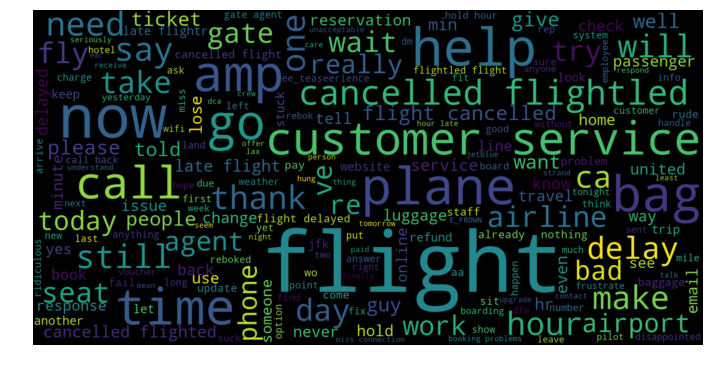

Wordcloud for Positive tweets - 


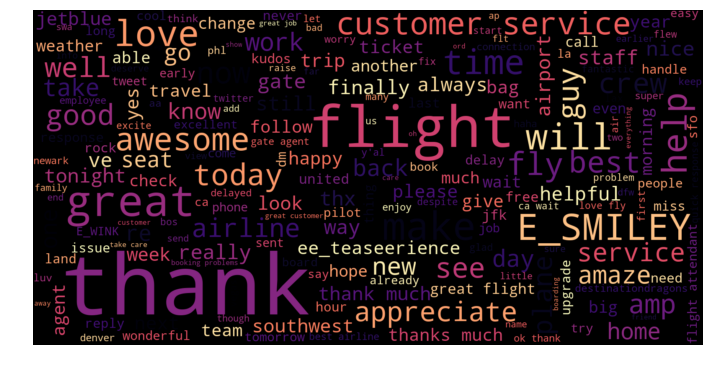

Wordcloud for Neutral tweets - 


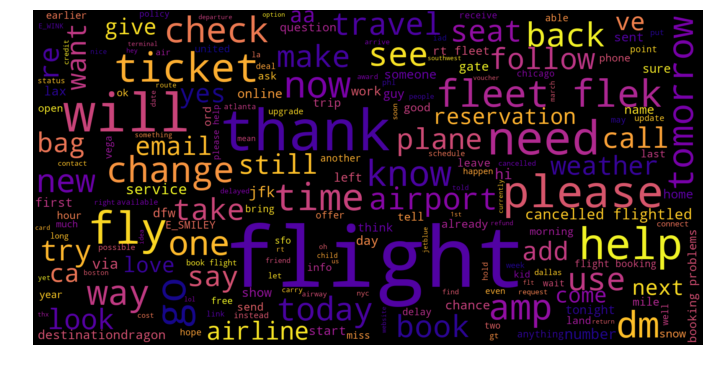

In [32]:
# word analysis

show_wordclouds()

### Extracting features using TfidfVectorizer()

In [33]:
vec = TfidfVectorizer(stop_words = stops, ngram_range = (1, 3), min_df = 0.0001)
x_train_features_tf = vec.fit_transform(clean_train_df.tweet)
x_test_features_tf = vec.transform(clean_test_df.tweet)
tokens_df = pd.DataFrame(vec.get_feature_names())
print("Number of tokens: ", tokens_df.shape[0])

Number of tokens:  17158


In [37]:
x_train_features_tf.todense()
x_train_features_dense = x_train_features_tf.toarray()
print("Train tokens: ", x_train_features_dense.shape)

Train tokens:  (10980, 17158)


In [38]:
x_test_features_tf.todense()
x_test_features_dense = x_train_features_tf.toarray()
print("Test tokens: ", x_test_features_dense.shape)

Test tokens:  (10980, 17158)


### Training, testing and predicting the sentiments

### Logistic Regression

In [56]:
# param_grid for Logistic Regression

C = [10**i for i in range(-5, 5)]
max_iter = [10**i for i in range(3, 6)]
param_grid = [{"C":C}, {"max_iter": max_iter}]print("Param_grid", param_grid)

Param_grid [{'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}, {'max_iter': [1000, 10000, 100000]}]


In [57]:
predicted_sentiment_LR = LR(x_train_features_dense, clean_train_df.sentiment, x_test_features_dense, param_grid)
np.savetxt('result_LR.csv', (predicted_sentiment_LR), delimiter=',', fmt = '%s')

Results for Logistic Regression: 
Score : 
0.893260473588
Classification report :
             precision    recall  f1-score   support

          0       0.92      0.95      0.93      6851
          2       0.83      0.76      0.79      2327
          4       0.88      0.85      0.86      1802

avg / total       0.89      0.89      0.89     10980



### Multinomial Naive bayes

In [60]:
predicted_sentiment_NB = NB(x_train_features_dense, clean_train_df.sentiment, x_test_features_dense)
np.savetxt('result_NB.csv', (predicted_sentiment_NB), delimiter=',', fmt = '%s')

Results for Multinomial Naive Bayes Classifier: 
Score : 
0.76393442623
Classification report :
             precision    recall  f1-score   support

          0       0.74      0.99      0.85      6851
          2       0.88      0.31      0.46      2327
          4       0.94      0.47      0.63      1802

avg / total       0.80      0.76      0.73     10980



### Random Forest

In [64]:
predicted_sentiment_RF = RF(x_train_features_dense, clean_train_df.sentiment, x_test_features_dense)
np.savetxt('result_RF.csv', (predicted_sentiment_RF), delimiter=',', fmt = '%s')

Results for Random Forest Classifier: 
Score : 
0.977686703097
Classification report :
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      6851
          2       0.98      0.94      0.96      2327
          4       0.97      0.96      0.97      1802

avg / total       0.98      0.98      0.98     10980

